In [1]:
"""Manejo de Informacion"""

import pandas as pd
import numpy as np
#from pandas import json_normalize
#import requests
#import json

#"""Tiempo"""

#from datetime import datetime
#from datetime import timezone

"""Textos"""

import re 
from unidecode import unidecode
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from itertools import chain
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter

"""Visualizaciones"""

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

"""ML"""

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None 

plt.rcParams["figure.figsize"] = (20,15)
plt.style.use('seaborn-poster')

# Limpiar datos

In [2]:
def CSV_transform(df):
    """
    Función que transforma de formato CSV a diccionario
    """
    
    df = df[~(df["lyrics"] == "error")] # No tomar en cuenta canciones que no tienen letra
    
    df["lyrics"] = df.lyrics.str.replace("\r"," ").str.replace("\n"," ").str.replace("[}{&:;,.¡!¿?\(\)\-\"\"0-9]","").str.replace("[","").str.replace("]","").str.lower() # Quitar espacios, interlineados, reemplazar algunos signos/numeros y pasar a minúsculas.
    
    df["lyrics"] = df.lyrics.apply(lambda x: unidecode(x)) # Quitar unicodes de la forma \uxxxx
    
    df["lyrics"] = df.lyrics.apply(lambda x: " ".join(x.split())) # Strippear el texto (quitar espacios innecesarios)
     
    return df

# Obtener Datos

Se tienen 3 datasets disponibles por si no se quiere/puede obtener la información personal.

In [3]:
df1 = CSV_transform(pd.read_csv("top_david_spotify.csv",usecols = ["name","lyrics"]).dropna().reset_index(drop = True))
df2 = CSV_transform(pd.read_csv("top_javier_spotify.csv",usecols = ["name","lyrics"]).dropna().reset_index(drop = True))
df3 = CSV_transform(pd.read_csv("top_jesus_spotify.csv",usecols = ["name","lyrics"]).dropna().reset_index(drop = True))

In [4]:
def Obtener_datos(numero):
    if numero == 1:
        return df1
    if numero == 2:
        return df2
    if numero == 3:
        return df3

# Obtener datos Estadísticos

In [5]:
df1_e = CSV_transform(pd.read_csv("top_david_spotify.csv",usecols = ["name","lyrics","danceability","energy","key","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]).dropna().reset_index(drop = True)).drop(columns = "lyrics")
df2_e = CSV_transform(pd.read_csv("top_javier_spotify.csv",usecols = ["name","lyrics","danceability","energy","key","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]).dropna().reset_index(drop = True)).drop(columns = "lyrics")
df3_e = CSV_transform(pd.read_csv("top_jesus_spotify.csv",usecols = ["name","lyrics","danceability","energy","key","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]).dropna().reset_index(drop = True)).drop(columns = "lyrics")

In [6]:
def Obtener_datos_estadisticos(numero):
    if numero == 1:
        return df1_e
    if numero == 2:
        return df2_e
    if numero == 3:
        return df3_e

# Naive Bayes Classifier para Identificar idioma

En este tópico utilizo:

1. __Tema 13: clasificador de Lengua (Naïve Bayes)__
2. __Tema 4: Matriz de Incidencia (frecuencias)__

Entrenar algorítmo de clasificación para clasificar entre 17 lenguas. Se utilizará el algorítmo visto en clase, pero implementado por Sklearn.

[El conjunto de datos etiquetado](https://www.kaggle.com/datasets/basilb2s/language-detection) fue extraido de Kaggle para facilitar el etiquetado. 

1) English
2) Malayalam
3) Hindi
4) Tamil
5) Kannada
6) French
7) Spanish
8) Portuguese
9) Italian
10) Russian
11) Sweedish
12) Dutch
13) Arabic
14) Turkish
15) German
16) Danish
17) Greek

__NOTA__: Dado que la longitud de las canciones no es tan extensa, no se aplicará ningún tipo de stemming. Tampoco considero necesario aplicar la técnica de los bigramas. 



In [7]:
# Cargar Dataset
lenguajes = pd.read_csv("Language Detection.csv")

# Realizar Matriz de Incidencias

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lenguajes.Text.str.replace("[{}:;,.¡!¿?\(\)\"\"0-9]","").to_list())

# Crear modelo 

NB = MultinomialNB() # Dejar prior como uniforme
NB.fit(X, lenguajes.Language.values)

MultinomialNB()

In [8]:
def Identificar_Idioma(df):
    X_test  = vectorizer.transform(df.lyrics)
    
    df["Idioma"] = NB.predict(X_test)
    
    return "Exitoso Identificador de Idioma"


# Completado de palabras en español en caso de contracción

En este tópico utilizo:

1. __Tema 6: Levenshtein Metric__

En español, como bien sabemos, no existen formalmente las contracciones; sin embargo, pragmáticamente se ha adquirido la costumbre de "recortar" algunas palabras y la forma de representar este fenómeno es por medio de un __'__. Comunmente estas contracciones se efectuan __en preposiciones__, esto es, stopwords. En cuanto a RI no son relevantes, pero para la interpretación literaria del texto, sí.

Se pretende identificar estas palabras y completarlas por medio de una lista de palabras comunmente contraidas (informalmente) en el español. De no detectarse alguna candidata, es mejor elimina la palabra por cuestiones de carácteres especiales.

In [9]:
def Contracciones_español(df,porcentaje = 60, lista_extra = []): 
    assert "Spanish" in df["Idioma"].unique(), 'No escuchas música en español'
    
    lista = lista_extra + [palabra for palabra in stopwords.words("Spanish") if len(palabra) >=3]
    
    español = df[df["Idioma"] == "Spanish"]["lyrics"]
    
    for indice in español.index:
            palabras_cancion = español[indice].split()
            
            for index in range(len(palabras_cancion)):
                if "'" in palabras_cancion[index]:
                    try:
                        palabras_cancion[index] =  process.extractOne(palabras_cancion[index], lista,score_cutoff = porcentaje)[0]
                    except:
                        palabras_cancion[index] = ""
                else:
                    pass
            
            cancion_corregida = " ".join(palabras_cancion)
            
            df.iloc[indice,1] = cancion_corregida
    
    return "Exitosa corrección de palabras en la lista"

# Contracciones general(')

En este tópico utilizo:

1. __Tema 3: Regex (Expresiones regulares)__

Dado que en algunas lenguas romances el uso de __'__ resulta determinante para el contexto de la oración, no puede ser fácilmente eliminado del corpus. En adición, las contracciones en el idioma inglés también existen y son muy comunes.  En general, en caso de que la contracción sea entre una preposición y una palabra relevante, es más probable que la palabra sea de mediana longitud. La función está primordialmente orientada a lenguas romance (incluyendo inglés) que las utilicen.

Se pretende identificar contracciones útiles por medio de la identificación de la longitud de la segunda palabra.

In [10]:
def Contracciones_general(df, limite = 4):
    
    
    idiomas = df[~(df["Idioma"] == "Spanish")]["lyrics"]
    
    for indice in idiomas.index:
            palabras_cancion = idiomas[indice].split()
            
            for index in range(len(palabras_cancion)):
                if "'" in palabras_cancion[index]:
                    
                    try:
                        palabras_cancion[index] =  re.search("(?<=')\w{4,}",palabras_cancion[index])[0]
                    except:
                        palabras_cancion[index] = ""
                else:
                    pass
            
            cancion_corregida = " ".join(palabras_cancion)
            
            df.iloc[indice,1] = cancion_corregida
    
    return "Exitosas correcciones generales de contracciones en la lista"

# Tokenizar Canciones

In [11]:
def Tokenizar(df):
    df["tokens"] = df["lyrics"].apply(lambda x: set(nltk.word_tokenize(x))) # Tokenizar las canciones
    
    return "Exitoso Tokenizado"

# Eliminar palabras de longitud mayor a...

In [12]:
def Eliminar_mayor_len(df,limite = 10):
    limpias = []
    for i in range(df.shape[0]):
        limpias.append({palabra_menos for palabra_menos in df.tokens[i] if len(palabra_menos) < limite})
    
    df["tokens"] = limpias
    
    return f"Exitosa eliminación de palabras con longitud mayor a {limite}"
                        

# Eliminar palabras de longitud menor a...

In [13]:
def Eliminar_menor_len(df,limite = 3):
    limpias = []
    for i in range(df.shape[0]):
        limpias.append({palabra_menos for palabra_menos in df.tokens[i] if len(palabra_menos) > limite})
    
    df["tokens"] = limpias
    
    return f"Exitosa eliminación de palabras con longitud menor a {limite}"

# Stopwords

In [14]:
def Stopwords(df, lista_extra = []):
    # Lista de idiomas
    idiomas = df.Idioma.unique()
    
    
    for idioma in idiomas:
        try:
            stopwords_ = stopwords.words(idioma) + lista_extra # Stopwords
        except:
            print("No hay stopwords para", idioma)
            
        canciones_idioma = df[df["Idioma"] == idioma]["tokens"]
        
        for indice in canciones_idioma.index:
            canciones_idioma[indice] = [palabra for palabra in canciones_idioma[indice] if palabra not in stopwords_]
            
        df.iloc[canciones_idioma.index,3] = canciones_idioma
        
    return "Exitosa eliminación de stopwords por idiomas identificados"
            

# WordClouds por idiomas

In [15]:
def WordClouds_idiomas(df):
    
    for idioma in df["Idioma"].unique():
    
        freq = " ".join(list(chain(*df[df["Idioma"] == idioma]["tokens"])))
        cloud = WordCloud(width = 8000,height = 8000, background_color = "black",max_words = 80).generate(freq)
    
        plt.figure(figsize=(25,15))
        plt.imshow(cloud, interpolation = "bilinear")
        plt.title(idioma, fontsize = 20, color = "black")
        plt.axis("off")
        plt.show()

# Stemmizar por idioma

En este tópico utilizo:

1. __Stemming__


La función solo está disponible para los siguientes idiomas:

1. arabic
2. danish
3. dutch
4. english
5. finnish
6. french
7. german
8. hungarian
9. italian
10. norwegian
11. portuguese
12. romanian
13. russian
14. spanish
15. swedish

De no estar disponible el idioma, simplemente se omite y se dejan los tokens originales.

In [16]:
def stemming_idiomas(df):
    
    df["tokens_stem"] = np.nan
    for idioma in df.Idioma.unique():
        
        try:
            stemmer = SnowballStemmer(idioma.lower())
            print(idioma, " ¡disponible para stemmizar!")
        except:
            continue
        
        canciones_idioma = df[df["Idioma"] == idioma]["tokens"]
        
        for indice in canciones_idioma.index:
            canciones_idioma[indice] = [stemmer.stem(palabra) for palabra in canciones_idioma[indice]]
            
        df.iloc[canciones_idioma.index,4] = canciones_idioma
        
    return "Exitosa eliminación de stopwords por idiomas identificados"

# Identificar palabras clave por (entre) canción(es)

En este tópico utilizo:

1. __Tema 8: TF-IDF__

Se busca obtener una aproximación al contexto de las canciones por medio del TF-IDF. Se pretende encontrar canciones con contextos parecidos. Se separa por idiomas para una mejor visualización, aunque ciertamente podría no hacerse y aún con eso el algortimo seguiría funcionando.

In [17]:
def palabras_mas_representativas_idioma(df, idioma):
    
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df[df["Idioma"] == idioma].tokens_stem.apply(lambda x: " ".join(x)).to_list())
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    tfidf = pd.DataFrame(denselist, columns=feature_names, index = df[df["Idioma"] == idioma].name)
    
    lista = {cancion: tfidf.loc[cancion,tfidf.loc[cancion,] == tfidf.loc[cancion,].max()].to_dict() for cancion in tfidf.index}
        
        
    
    return lista
    

# Clustering respecto a Métricas Spotify

En este tópico utilizo:

1. __PCA__



In [18]:
datos = pd.concat([Obtener_datos_estadisticos(1),Obtener_datos_estadisticos(2),Obtener_datos_estadisticos(3)]).drop_duplicates()

In [19]:
datos

,name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,Star Treatment,0.581,0.767,7,-5.026,0.0527,0.24300,0.001310,0.1410,0.673
1,Fireside,0.538,0.953,9,-5.611,0.0560,0.02340,0.001260,0.1130,0.740
2,Veneno,0.730,0.664,2,-6.872,0.0346,0.37200,0.000000,0.2250,0.719
3,Cuando Me Acerco A Ti,0.736,0.543,9,-9.037,0.2400,0.18300,0.000000,0.1970,0.245
4,Cornerstone,0.287,0.721,9,-5.810,0.0387,0.00764,0.000000,0.3280,0.763
...,...,...,...,...,...,...,...,...,...,...
31,Snowman,0.716,0.512,1,-6.257,0.0331,0.48300,0.000000,0.0928,0.326
32,Si El Mundo Se Acabara,0.543,0.826,9,-2.394,0.3060,0.59400,0.000003,0.1200,0.573
33,Riesgo,0.363,0.329,9,-14.479,0.0415,0.75900,0.000000,0.0936,0.260
34,Snap Out Of It,0.728,0.638,5,-6.455,0.0336,0.24900,0.000000,0.1160,0.872


## Matriz de correlaciones

No hay variables que se correlaciones de manera severa. 

In [20]:
datos.corr("spearman")

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence
danceability,1.000000,-0.169830,0.039517,-0.032119,0.252009,0.238652,-0.146481,-0.150897,0.391040
energy,-0.169830,1.000000,-0.078402,0.633507,0.267070,-0.479946,0.067313,0.172425,0.336030
key,0.039517,-0.078402,1.000000,-0.086927,-0.011763,0.111314,0.069517,0.057941,0.007006
loudness,-0.032119,0.633507,-0.086927,1.000000,0.344719,-0.321158,-0.256292,0.176325,0.294261
speechiness,0.252009,0.267070,-0.011763,0.344719,1.000000,0.111999,-0.384349,-0.007147,0.148022
acousticness,0.238652,-0.479946,0.111314,-0.321158,0.111999,1.000000,-0.408549,-0.156310,-0.013221
instrumentalness,-0.146481,0.067313,0.069517,-0.256292,-0.384349,-0.408549,1.000000,0.098499,-0.072987
liveness,-0.150897,0.172425,0.057941,0.176325,-0.007147,-0.156310,0.098499,1.000000,0.044799
valence,0.391040,0.336030,0.007006,0.294261,0.148022,-0.013221,-0.072987,0.044799,1.000000


Tanto `key` como `loudness` tienen una varianza mayor. Es necesario escalarlas. Las demás variables ya se encuentran reescaladas, pero podría disminuirla la desviación estandar un poco más en aras de una mejor captura de los componentes principales. 

In [21]:
datos.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,0.625430,0.660121,5.420561,-6.595561,0.075894,0.239121,0.063864,0.176042,0.583967
std,0.142558,0.182237,3.816640,2.634927,0.077583,0.237055,0.172766,0.126959,0.211659
min,0.216000,0.179000,0.000000,-15.651000,0.023800,0.000217,0.000000,0.021500,0.069500
25%,0.530500,0.527000,1.500000,-7.693500,0.033150,0.034950,0.000000,0.099750,0.424000
50%,0.652000,0.678000,6.000000,-6.039000,0.043900,0.165000,0.000006,0.124000,0.590000
75%,0.731000,0.801000,9.000000,-4.908000,0.071300,0.402500,0.002020,0.225000,0.750500
max,0.912000,0.975000,11.000000,-0.390000,0.374000,0.879000,0.855000,0.788000,0.973000


## Standard Scaler

In [22]:
datos[['key', 'loudness']] = StandardScaler().fit_transform(datos[['key', 'loudness']])

In [23]:
datos

,name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,Star Treatment,0.581,0.767,0.415777,0.598478,0.0527,0.24300,0.001310,0.1410,0.673
1,Fireside,0.538,0.953,0.942264,0.375416,0.0560,0.02340,0.001260,0.1130,0.740
2,Veneno,0.730,0.664,-0.900441,-0.105407,0.0346,0.37200,0.000000,0.2250,0.719
3,Cuando Me Acerco A Ti,0.736,0.543,0.942264,-0.930928,0.2400,0.18300,0.000000,0.1970,0.245
4,Cornerstone,0.287,0.721,0.942264,0.299537,0.0387,0.00764,0.000000,0.3280,0.763
...,...,...,...,...,...,...,...,...,...,...
31,Snowman,0.716,0.512,-1.163684,0.129094,0.0331,0.48300,0.000000,0.0928,0.326
32,Si El Mundo Se Acabara,0.543,0.826,0.942264,1.602068,0.3060,0.59400,0.000003,0.1200,0.573
33,Riesgo,0.363,0.329,0.942264,-3.005980,0.0415,0.75900,0.000000,0.0936,0.260
34,Snap Out Of It,0.728,0.638,-0.110710,0.053596,0.0336,0.24900,0.000000,0.1160,0.872


In [24]:
datos.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence
count,107.000000,107.000000,1.070000e+02,1.070000e+02,107.000000,107.000000,107.000000,107.000000,107.000000
mean,0.625430,0.660121,-4.669162e-17,-1.219170e-17,0.075894,0.239121,0.063864,0.176042,0.583967
std,0.142558,0.182237,1.004706e+00,1.004706e+00,0.077583,0.237055,0.172766,0.126959,0.211659
min,0.216000,0.179000,-1.426928e+00,-3.452868e+00,0.023800,0.000217,0.000000,0.021500,0.069500
25%,0.530500,0.527000,-1.032062e+00,-4.186477e-01,0.033150,0.034950,0.000000,0.099750,0.424000
50%,0.652000,0.678000,1.525336e-01,2.122184e-01,0.043900,0.165000,0.000006,0.124000,0.590000
75%,0.731000,0.801000,9.422643e-01,6.434722e-01,0.071300,0.402500,0.002020,0.225000,0.750500
max,0.912000,0.975000,1.468751e+00,2.366200e+00,0.374000,0.879000,0.855000,0.788000,0.973000


In [25]:
X = datos.iloc[:,1:].values

## PCA

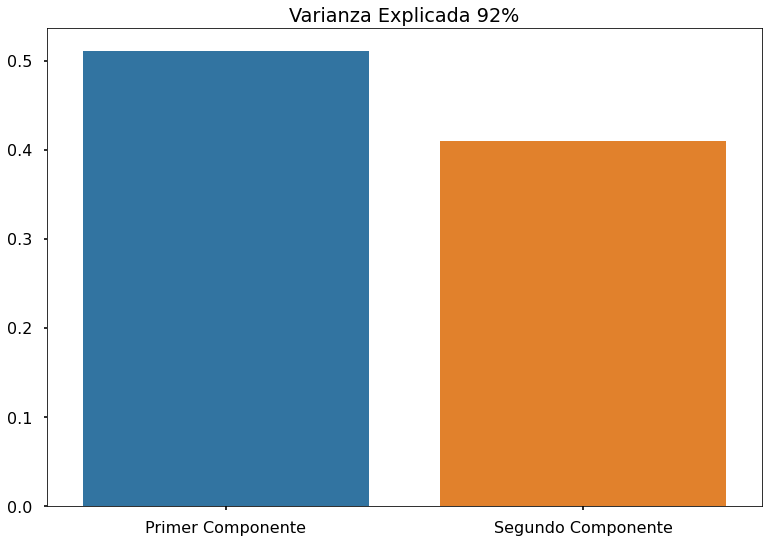

In [26]:
pca = PCA(n_components = 2) 
  
X_pca = pca.fit_transform(X) 
 
explained_variance = pca.explained_variance_ratio_ 

principalDf = pd.DataFrame(data = X_pca, columns = ['Componente1', 'Componente2'])

sns.barplot(x = ["Primer Componente","Segundo Componente"], y = explained_variance)
plt.title("Varianza Explicada 92%")
plt.show()

## K means

In [27]:
X = np.array(X_pca)

La curva del codo sugiere que 4 clusters son los indispensables.

C:\Users\actda\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


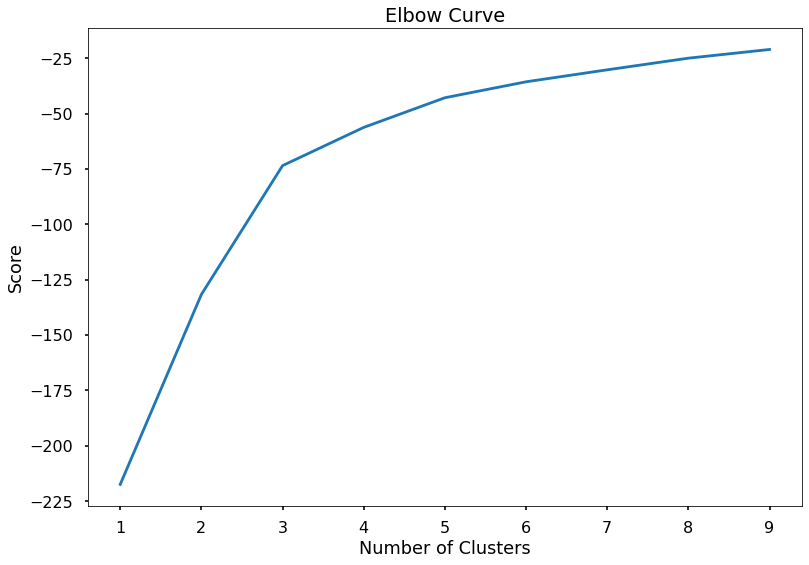

In [28]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

La gráfica de silueta también da buenos resultados con 4 clusters.

For n_clusters = 2 The average silhouette_score is : 0.40106128486655634
For n_clusters = 3 The average silhouette_score is : 0.4638337543717388
For n_clusters = 4 The average silhouette_score is : 0.4387500008162462
For n_clusters = 5 The average silhouette_score is : 0.41529636921763435
For n_clusters = 6 The average silhouette_score is : 0.40600156474145377


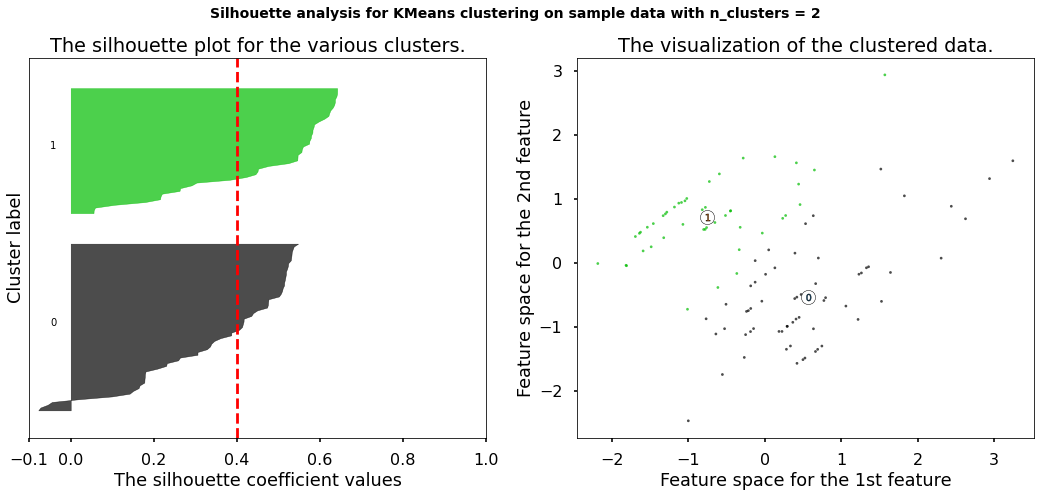

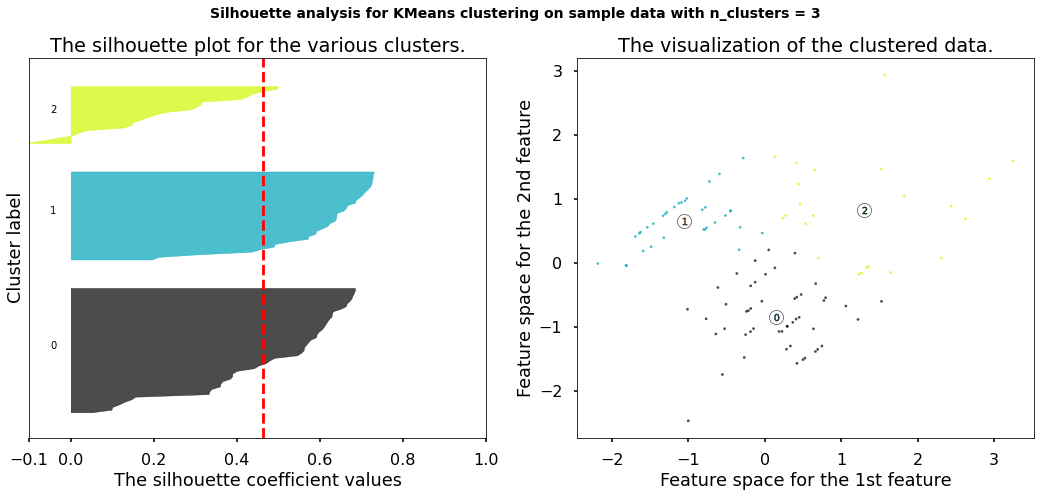

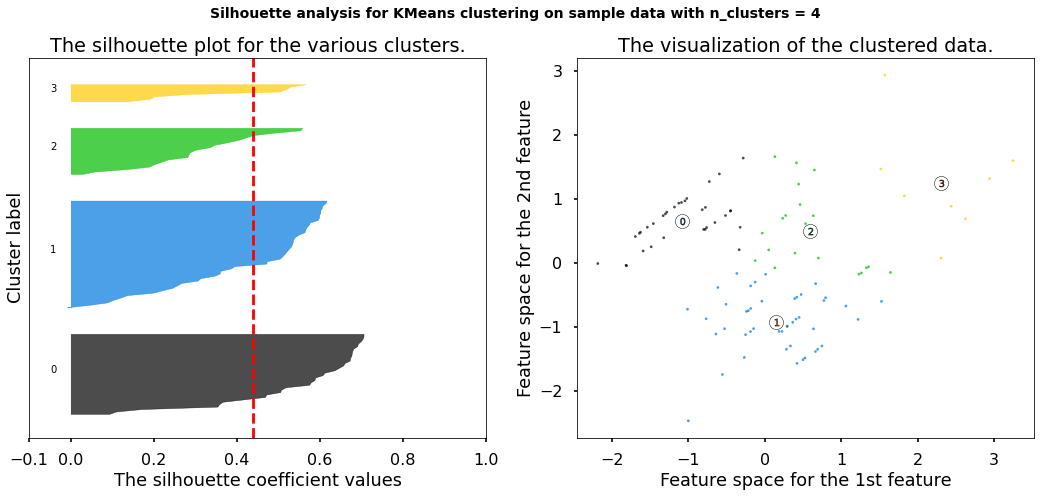

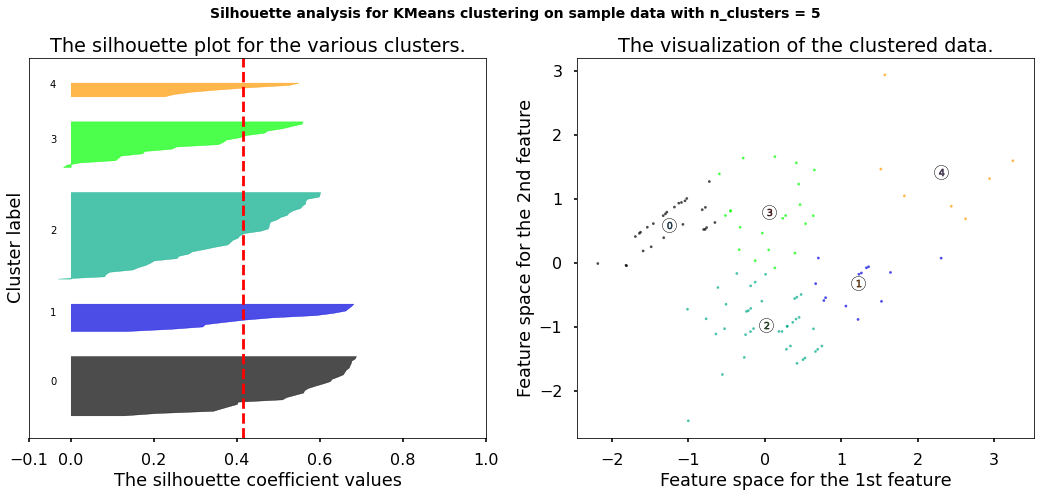

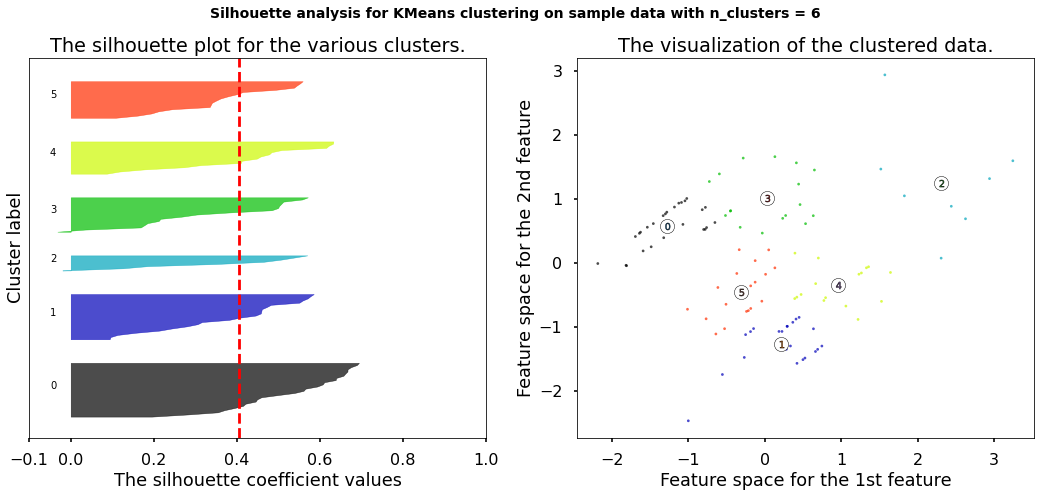

In [29]:
# Tomado de: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [30]:
kmeans = KMeans(n_clusters=4, random_state=8).fit(X)
labels = kmeans.predict(X)

datos["labels"] = labels

In [31]:
datos.groupby("labels")["name"].count()

labels
0    43
1    34
2    22
3     8
Name: name, dtype: int64

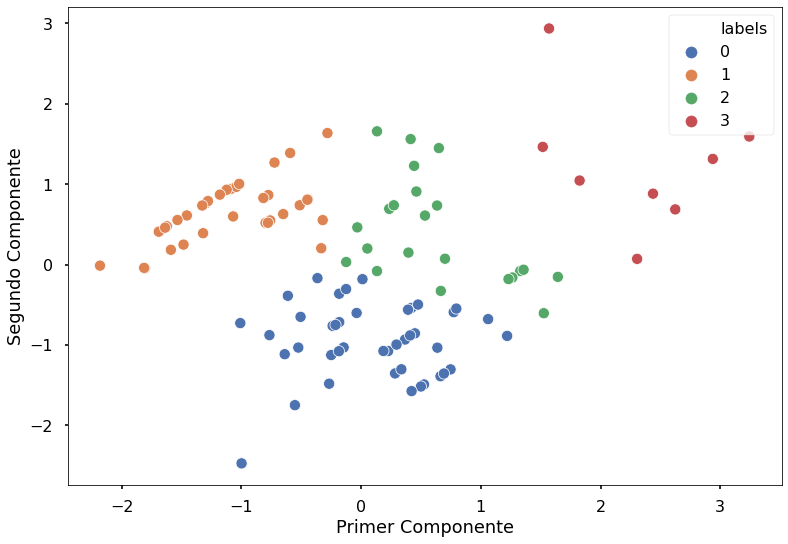

In [32]:
a = pd.DataFrame(X)
a["labels"] = labels
sns.scatterplot(data=a, x=0, y=1, hue = "labels",palette="deep")
plt.xlabel("Primer Componente")
plt.ylabel("Segundo Componente")
plt.show()

## Descripción por clusters

1. __Grupo 0 (a toda madre)__: Canciones llenas de Energía, te dan ganas de bailarlas.

2. __Grupo 1 (fuera de este mundo)__: Pasas el rato y escuchar música te saca de este mundo. 

3. __Grupo 2 (cansado, escuchando música porque andas aburrido)__: Canciones energéticas, pero no tan ruidosas. Canciones para concentrarse.

4. __Grupo 3 (¿Todo bien, bro?)__: Cansiones en su mayoría con una valencia baja y muy poco energéticas. En su mayoría son canciones acústicas.

In [34]:
def Cluster_canciones(df, test_e):
    
    test_e[['key', 'loudness']] = StandardScaler().fit_transform(test_e[['key', 'loudness']])
    
    X = test_e.iloc[:,1:].values
    
    X_pca = pca.transform(X) 
    
    X = np.array(X_pca)
    
    labels = kmeans.predict(X)
    
    df["Tipo"] = labels
    
    df["Tipo"] = df["Tipo"].replace(0,"A toda madre").replace(1,"fuera de este mundo").replace(2,"cansado/aburrido").replace(3,"¿Todo bien,bro?")
    
    return "¡Exitoso etiquetado"

## MASTER

In [35]:
def master(df,df_e, limite_mas = 10, limite_menos = 3, stopwords = []):
    Identificar_Idioma(test)
    
    try:
        Contracciones_español(test)
    except AssertionError as msg:
        print(msg)

    Contracciones_general(test)

    Tokenizar(test)

    Eliminar_mayor_len(test, limite_mas)

    Eliminar_menor_len(test, limite_menos)

    Stopwords(test, stopwords) 

    # WordClouds_idiomas(test)

    stemming_idiomas(test)

    #palabras_mas_representativas_idioma(test, "English")

    Cluster_canciones(test,test_e)
    
    return "¡Todo listo!"